### imports

In [94]:
import re
import json
import string
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import nltk

from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from glob import glob
from tqdm import tqdm as tq
from tqdm import tqdm_notebook as tqdm

warnings.filterwarnings(action='ignore')
tq.pandas()
%matplotlib inline
nltk.download('wordnet')
stop = stopwords.words('english')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### to make the plots look better

In [2]:
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
sns.set_context('paper')
sns.set(font_scale=1.5)

### loading data

In [3]:
files = glob("json/*.json")

In [132]:
len(files)

12773

In [5]:
with open(files[0], 'r') as file:
    data = json.load(file)

In [6]:
data.keys()

dict_keys(['Reviews', 'HotelInfo'])

In [7]:
df_list = list()
for file in tqdm(files[:6500]): ## using a little more than 50% data
    with open(file, 'r') as f:
        data = json.load(f)
        reviews = pd.io.json.json_normalize(data['Reviews'], sep='-')
        hotelinfo = pd.io.json.json_normalize(data['HotelInfo'], sep='-')
        hotelinfo = hotelinfo.loc[hotelinfo.index.repeat(len(reviews))]
        reviews.reset_index(drop=True, inplace=True)
        hotelinfo.reset_index(drop=True, inplace=True)
        df = pd.concat([reviews, hotelinfo], axis=1)
        df_list.append(df)

HBox(children=(IntProgress(value=0, max=6500), HTML(value='')))

In [8]:
df = pd.concat(df_list, sort=False)

In [9]:
df.reset_index(drop=True, inplace=True)

### checking memory usage

In [10]:
df.memory_usage(index=True).sum()/(1024**2)  ## in MB

146.59523010253906

### looking into data

In [11]:
df.head()

,AuthorLocation,Title,Author,ReviewID,Content,Date,Ratings-Service,Ratings-Cleanliness,Ratings-Overall,Ratings-Value,...,Ratings-Location,"Ratings-Business service (e.g., internet access)",Ratings-Check in / front desk,Name,HotelURL,Price,Address,HotelID,ImgURL,Ratings-Business service
0,"Jacksonville, Florida",“Great place and location”,Nadine R,UR128178025,"Usually stay near the airport, but this trip w...","April 19, 2012",5,5,5.0,5,...,5,NaN,NaN,Hilton Garden Inn Baltimore White Marsh,/ShowUserReviews-g60811-d100407-Reviews-Hilton...,$135 - $193*,"<address><span rel=""v:address""><span dir=""ltr""...",100407,http://media-cdn.tripadvisor.com/media/Provide...,NaN
1,"Chillicothe, Ohio","“Nice stay, nice surroundings”",blt3116,UR123847354,Stayed at this Hilton for 2 nights. It was lik...,"January 30, 2012",4,4,4.0,4,...,5,NaN,NaN,Hilton Garden Inn Baltimore White Marsh,/ShowUserReviews-g60811-d100407-Reviews-Hilton...,$135 - $193*,"<address><span rel=""v:address""><span dir=""ltr""...",100407,http://media-cdn.tripadvisor.com/media/Provide...,NaN
2,Northern Virginia,“Perfect for an overnight just off I-95”,ExSpec5,UR122192448,"Stayed there one night, December 16, on the wa...","December 28, 2011",5,5,4.0,3,...,5,NaN,NaN,Hilton Garden Inn Baltimore White Marsh,/ShowUserReviews-g60811-d100407-Reviews-Hilton...,$135 - $193*,"<address><span rel=""v:address""><span dir=""ltr""...",100407,http://media-cdn.tripadvisor.com/media/Provide...,NaN
3,Raleigh,“Great Hotel”,kevinlynch3,UR122031890,I just stayed here last weekend and have alrea...,"December 23, 2011",5,5,5.0,4,...,5,NaN,NaN,Hilton Garden Inn Baltimore White Marsh,/ShowUserReviews-g60811-d100407-Reviews-Hilton...,$135 - $193*,"<address><span rel=""v:address""><span dir=""ltr""...",100407,http://media-cdn.tripadvisor.com/media/Provide...,NaN
4,"Belmont, MA",“good room for handicapped person”,nobumponalog,UR119295575,My mother who is 90 and I stayed one night on ...,"October 14, 2011",5,5,5.0,4,...,5,NaN,NaN,Hilton Garden Inn Baltimore White Marsh,/ShowUserReviews-g60811-d100407-Reviews-Hilton...,$135 - $193*,"<address><span rel=""v:address""><span dir=""ltr""...",100407,http://media-cdn.tripadvisor.com/media/Provide...,NaN


In [12]:
df.shape

(873387, 22)

In [13]:
df.columns

Index(['AuthorLocation', 'Title', 'Author', 'ReviewID', 'Content', 'Date',
       'Ratings-Service', 'Ratings-Cleanliness', 'Ratings-Overall',
       'Ratings-Value', 'Ratings-Sleep Quality', 'Ratings-Rooms',
       'Ratings-Location', 'Ratings-Business service (e.g., internet access)',
       'Ratings-Check in / front desk', 'Name', 'HotelURL', 'Price', 'Address',
       'HotelID', 'ImgURL', 'Ratings-Business service'],
      dtype='object')

NOTE: 2 similar columns (Ratings-Business service, Ratings-Business service (e.g., internet access))

checking if there are any overlapping values for these columns

In [14]:
df[(df['Ratings-Business service (e.g., internet access)'].notnull()) & (df['Ratings-Business service'].notnull())]

,AuthorLocation,Title,Author,ReviewID,Content,Date,Ratings-Service,Ratings-Cleanliness,Ratings-Overall,Ratings-Value,...,Ratings-Location,"Ratings-Business service (e.g., internet access)",Ratings-Check in / front desk,Name,HotelURL,Price,Address,HotelID,ImgURL,Ratings-Business service


no overlapping values. So we can merge them.

In [15]:
df.count()

AuthorLocation                                      820475
Title                                               820475
Author                                              873387
ReviewID                                            873387
Content                                             873387
Date                                                873387
Ratings-Service                                     798764
Ratings-Cleanliness                                 797389
Ratings-Overall                                     873387
Ratings-Value                                       798740
Ratings-Sleep Quality                               433139
Ratings-Rooms                                       724624
Ratings-Location                                    684049
Ratings-Business service (e.g., internet access)     83502
Ratings-Check in / front desk                       190600
Name                                                820475
HotelURL                                            8701

Ratings-Business service (e.g., internet access) -> 83502

Ratings-Business service -> 52912

Combined column should be -> 136414

In [12]:
df['Ratings-Business service'].fillna(df['Ratings-Business service (e.g., internet access)'], inplace=True)

In [13]:
df['Ratings-Business service'].count()

136414

### dropping unwanted columns

In [13]:
df.columns

Index(['AuthorLocation', 'Title', 'Author', 'ReviewID', 'Content', 'Date',
       'Ratings-Service', 'Ratings-Cleanliness', 'Ratings-Overall',
       'Ratings-Value', 'Ratings-Sleep Quality', 'Ratings-Rooms',
       'Ratings-Location', 'Ratings-Business service (e.g., internet access)',
       'Ratings-Check in / front desk', 'Name', 'HotelURL', 'Price', 'Address',
       'HotelID', 'ImgURL', 'Ratings-Business service'],
      dtype='object')

In [14]:
unwanted_columns = ['Ratings-Business service (e.g., internet access)', 'HotelURL', 'ImgURL', 'AuthorLocation', 'ReviewID', 'Date', 'Address']

In [15]:
df_clean = df.drop(unwanted_columns, axis=1)

### EDA

In [16]:
df_clean.head()

,Title,Author,Content,Ratings-Service,Ratings-Cleanliness,Ratings-Overall,Ratings-Value,Ratings-Sleep Quality,Ratings-Rooms,Ratings-Location,Ratings-Check in / front desk,Name,Price,HotelID,Ratings-Business service
0,“Great place and location”,Nadine R,"Usually stay near the airport, but this trip w...",5,5,5.0,5,5,5,5,NaN,Hilton Garden Inn Baltimore White Marsh,$135 - $193*,100407,NaN
1,"“Nice stay, nice surroundings”",blt3116,Stayed at this Hilton for 2 nights. It was lik...,4,4,4.0,4,4,4,5,NaN,Hilton Garden Inn Baltimore White Marsh,$135 - $193*,100407,NaN
2,“Perfect for an overnight just off I-95”,ExSpec5,"Stayed there one night, December 16, on the wa...",5,5,4.0,3,3,5,5,NaN,Hilton Garden Inn Baltimore White Marsh,$135 - $193*,100407,NaN
3,“Great Hotel”,kevinlynch3,I just stayed here last weekend and have alrea...,5,5,5.0,4,5,5,5,NaN,Hilton Garden Inn Baltimore White Marsh,$135 - $193*,100407,NaN
4,“good room for handicapped person”,nobumponalog,My mother who is 90 and I stayed one night on ...,5,5,5.0,4,5,5,5,NaN,Hilton Garden Inn Baltimore White Marsh,$135 - $193*,100407,NaN


In [22]:
df_clean.count()

Title                            820475
Author                           873387
Content                          873387
Ratings-Service                  798764
Ratings-Cleanliness              797389
Ratings-Overall                  873387
Ratings-Value                    798740
Ratings-Sleep Quality            433139
Ratings-Rooms                    724624
Ratings-Location                 684049
Ratings-Check in / front desk    190600
Name                             820475
Price                            873387
HotelID                          873387
Ratings-Business service         136414
dtype: int64

In [44]:
temp = df_clean['Author'].value_counts()
temp[temp>15].count()

317

#### total unique hotels

In [58]:
temp = df_clean['HotelID'].value_counts()
temp[temp>0].count()

6482

In [25]:
df_clean.describe()

,Title,Author,Content,Ratings-Service,Ratings-Cleanliness,Ratings-Overall,Ratings-Value,Ratings-Sleep Quality,Ratings-Rooms,Ratings-Location,Ratings-Check in / front desk,Name,Price,HotelID,Ratings-Business service
count,820475,873387,873387,798764,797389,873387,798740,433139,724624,684049,190600,820475,873387,873387,136414
unique,460184,500218,682408,6,6,12,6,5,6,6,6,4491,4507,6482,6
top,“Great Location”,A TripAdvisor Member,"I recently stayed at this hotel, primarily bec...",5,5,5.0,5,5,5,5,5,Hotel Pennsylvania New York,$109 - $278*,2515499,-1
freq,2984,41018,8,388843,438386,343588,319685,217502,277989,393967,74014,6261,5209,4936,37073


In [26]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 873387 entries, 0 to 873386
Data columns (total 15 columns):
Title                            820475 non-null object
Author                           873387 non-null object
Content                          873387 non-null object
Ratings-Service                  798764 non-null object
Ratings-Cleanliness              797389 non-null object
Ratings-Overall                  873387 non-null object
Ratings-Value                    798740 non-null object
Ratings-Sleep Quality            433139 non-null object
Ratings-Rooms                    724624 non-null object
Ratings-Location                 684049 non-null object
Ratings-Check in / front desk    190600 non-null object
Name                             820475 non-null object
Price                            873387 non-null object
HotelID                          873387 non-null object
Ratings-Business service         136414 non-null object
dtypes: object(15)
memory usage: 100.0+ MB


#### converting rating columns to numeric

In [17]:
df_clean = df_clean.apply(pd.to_numeric, errors='ignore')

In [18]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 873387 entries, 0 to 873386
Data columns (total 15 columns):
Title                            820475 non-null object
Author                           873387 non-null object
Content                          873387 non-null object
Ratings-Service                  798764 non-null float64
Ratings-Cleanliness              797389 non-null float64
Ratings-Overall                  873387 non-null float64
Ratings-Value                    798740 non-null float64
Ratings-Sleep Quality            433139 non-null float64
Ratings-Rooms                    724624 non-null float64
Ratings-Location                 684049 non-null float64
Ratings-Check in / front desk    190600 non-null float64
Name                             820475 non-null object
Price                            873387 non-null object
HotelID                          873387 non-null int64
Ratings-Business service         136414 non-null float64
dtypes: float64(9), int64(1), object(5)
m

In [29]:
df_clean.head()

,Title,Author,Content,Ratings-Service,Ratings-Cleanliness,Ratings-Overall,Ratings-Value,Ratings-Sleep Quality,Ratings-Rooms,Ratings-Location,Ratings-Check in / front desk,Name,Price,HotelID,Ratings-Business service
0,“Great place and location”,Nadine R,"Usually stay near the airport, but this trip w...",5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,Hilton Garden Inn Baltimore White Marsh,$135 - $193*,100407,NaN
1,"“Nice stay, nice surroundings”",blt3116,Stayed at this Hilton for 2 nights. It was lik...,4.0,4.0,4.0,4.0,4.0,4.0,5.0,NaN,Hilton Garden Inn Baltimore White Marsh,$135 - $193*,100407,NaN
2,“Perfect for an overnight just off I-95”,ExSpec5,"Stayed there one night, December 16, on the wa...",5.0,5.0,4.0,3.0,3.0,5.0,5.0,NaN,Hilton Garden Inn Baltimore White Marsh,$135 - $193*,100407,NaN
3,“Great Hotel”,kevinlynch3,I just stayed here last weekend and have alrea...,5.0,5.0,5.0,4.0,5.0,5.0,5.0,NaN,Hilton Garden Inn Baltimore White Marsh,$135 - $193*,100407,NaN
4,“good room for handicapped person”,nobumponalog,My mother who is 90 and I stayed one night on ...,5.0,5.0,5.0,4.0,5.0,5.0,5.0,NaN,Hilton Garden Inn Baltimore White Marsh,$135 - $193*,100407,NaN


In [30]:
df_clean.describe()

,Ratings-Service,Ratings-Cleanliness,Ratings-Overall,Ratings-Value,Ratings-Sleep Quality,Ratings-Rooms,Ratings-Location,Ratings-Check in / front desk,HotelID,Ratings-Business service
count,798764.000000,797389.000000,873387.000000,798740.000000,433139.000000,724624.000000,684049.000000,190600.000000,8.733870e+05,136414.000000
mean,3.952972,4.138280,3.939649,3.794202,4.108900,3.792058,4.163670,3.197639,1.218297e+06,2.342172
std,1.375918,1.287416,1.206752,1.401455,1.148362,1.356370,1.399444,2.102603,1.092890e+06,2.303823
min,-1.000000,-1.000000,0.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.004070e+05,-1.000000
25%,3.000000,4.000000,3.000000,3.000000,4.000000,3.000000,4.000000,2.000000,2.025810e+05,-1.000000
50%,4.000000,5.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,2.498310e+05,3.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.514695e+06,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.515692e+06,5.000000


Averate overall ratings is 3.94, which means most of the hotels have good rating i.e. 4, 5

#### most and highest rated hotel

In [50]:
df_most_rated = df_clean.groupby(by='HotelID', as_index=False)['Ratings-Overall'].agg({'Ratings-Overall': 'mean', 'Price': 'count'}).rename(columns={'Price': 'Count'})

In [67]:
df_most_rated.sort_values(['Count', 'Ratings-Overall'], ascending=False).head()

,HotelID,Ratings-Overall,Count
6288,2515499,4.226297,4936
6232,2515443,4.148743,3738
6465,2515676,3.675000,3120
6422,2515633,3.989769,3030
6329,2515540,4.240324,2842


In [134]:
df_clean[df_clean['HotelID'] == 2515499].head(1)

,Title,Author,Content,Ratings-Service,Ratings-Cleanliness,Ratings-Overall,Ratings-Value,Ratings-Sleep Quality,Ratings-Rooms,Ratings-Location,Ratings-Check in / front desk,Name,Price,HotelID,Ratings-Business service,Clean_Content,Word_Count
800114,“Poor Customer Service”,TdHCanada,"First off...beautiful hotel, gorgeous fountain...",2.0,5.0,3.0,3.0,5.0,5.0,5.0,NaN,Bellagio Las Vegas,$178 - $365*,2515499,NaN,first off beautiful hotel gorgeous fountain un...,154


In [68]:
df_most_rated.sort_values(['Ratings-Overall', 'Count'], ascending=False).head()

,HotelID,Ratings-Overall,Count
3679,1101456,5.0,12
5875,2515086,5.0,11
6377,2515588,5.0,11
3578,1082544,5.0,10
4788,1978931,5.0,10


In [133]:
df_clean[df_clean['HotelID'] == 1101456].head(1)

,Title,Author,Content,Ratings-Service,Ratings-Cleanliness,Ratings-Overall,Ratings-Value,Ratings-Sleep Quality,Ratings-Rooms,Ratings-Location,Ratings-Check in / front desk,Name,Price,HotelID,Ratings-Business service,Clean_Content,Word_Count
33717,NaN,JTNL,Best place and wonderful people inside t...,5.0,5.0,5.0,5.0,NaN,4.0,5.0,5.0,NaN,Unkonwn,1101456,4.0,best place and wonderful people inside the cot...,8


1. Bellagio Las Vegas (HotelID: 2515499) is the most rated hotel: 4936, with average Rating: 4.2
2. Hotel with ID: 1101456 has best rating (all 5 stars) with most reviews: 12. It has no name in the data.

#### most reviews on a day

In [69]:
df['Date'].value_counts().head(10)

September 12, 2011    2897
July 28, 2011         2572
June 13, 2011         2527
October 31, 2011      2068
July 29, 2011         1967
February 20, 2012     1840
November 28, 2011     1802
July 27, 2011         1571
October 8, 2009       1563
January 5, 2012       1553
Name: Date, dtype: int64

1. September 12, 2011 has most reviews: 2897
2. Looks like year 2011 has most reviews. (Maybe people travelled more in 2011 or tripAdvisor did something to get more reviews like marketing/offers).

#### grouping hotels on the basis of Overall Ratings

In [19]:
df_hotelsgroup = df_clean.groupby(by='HotelID', as_index=False)['Ratings-Overall'].mean()

In [20]:
df_hotelsgroup

,HotelID,Ratings-Overall
0,100407,4.444444
1,100504,4.481043
2,100505,3.567114
3,100506,1.666667
4,100507,4.715370
...,...,...
6477,2515688,3.543103
6478,2515689,3.899083
6479,2515690,3.696429
6480,2515691,4.058824


#### rounding off average rating of hotels to multiple of 0.5 and 1

In [21]:
def myround(x, prec=1, base=.5):
    return round(base * round(float(x)/base),prec)

In [22]:
df_hotelsgroup['Ratings-RoundedOffhalf'] = df_hotelsgroup['Ratings-Overall'].apply(lambda x: myround(x))

In [23]:
df_hotelsgroup['Ratings-RoundedOffone'] = df_hotelsgroup['Ratings-Overall'].apply(lambda x: round(x))

In [24]:
df_hotelsgroup

,HotelID,Ratings-Overall,Ratings-RoundedOffhalf,Ratings-RoundedOffone
0,100407,4.444444,4.5,4
1,100504,4.481043,4.5,4
2,100505,3.567114,3.5,4
3,100506,1.666667,1.5,2
4,100507,4.715370,4.5,5
...,...,...,...,...
6477,2515688,3.543103,3.5,4
6478,2515689,3.899083,4.0,4
6479,2515690,3.696429,3.5,4
6480,2515691,4.058824,4.0,4


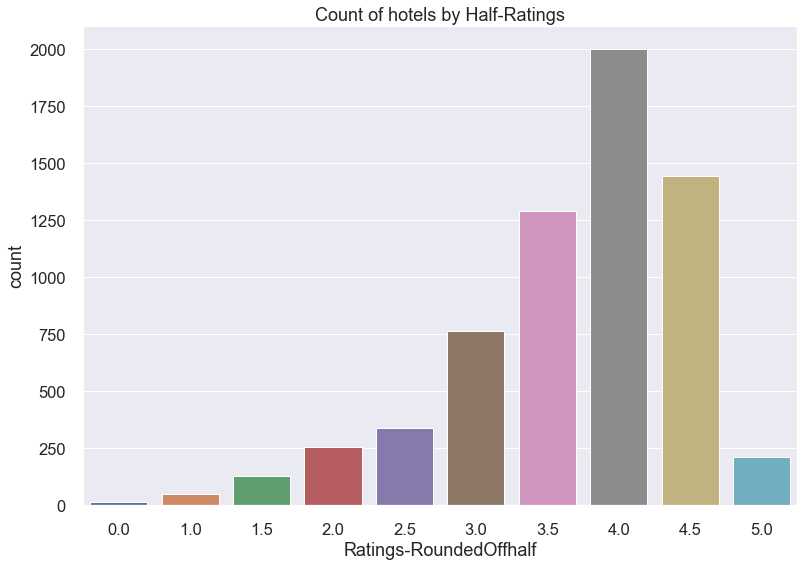

In [37]:
sns.countplot(x='Ratings-RoundedOffhalf', data=df_hotelsgroup).set_title("Count of hotels by Half-Ratings");

Most of the hotels are rated between 3.5 to 4.5 average

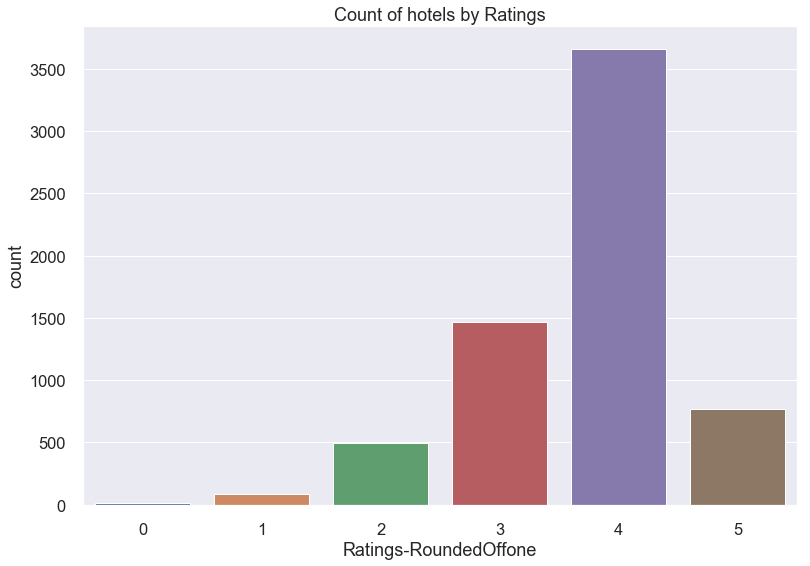

In [38]:
sns.countplot(x='Ratings-RoundedOffone', data=df_hotelsgroup).set_title("Count of hotels by Ratings");

#### ratings distribution

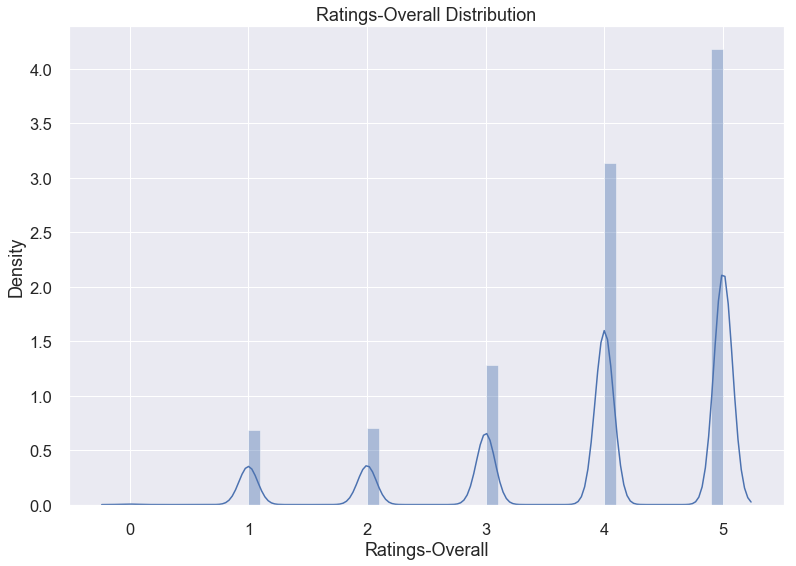

In [39]:
sns.distplot(df_clean['Ratings-Overall']).set_title("Ratings-Overall Distribution");

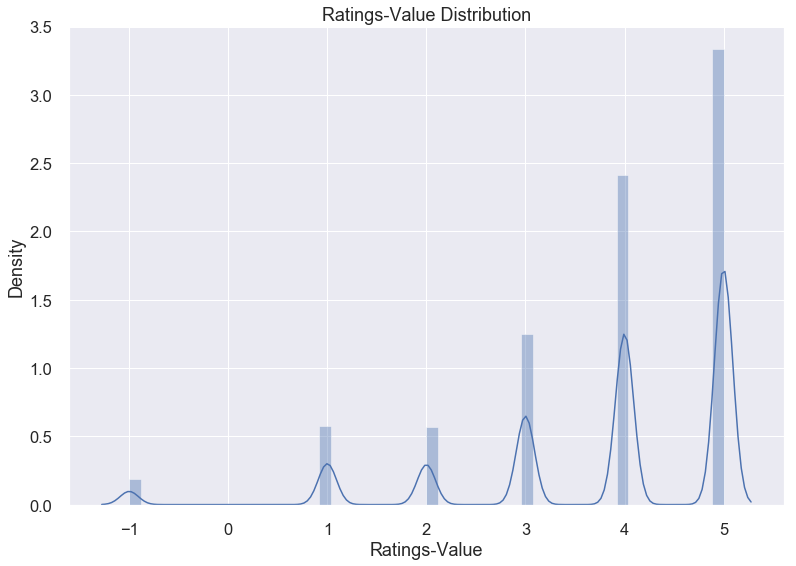

In [40]:
sns.distplot(df_clean['Ratings-Value'].dropna()).set_title("Ratings-Value Distribution");

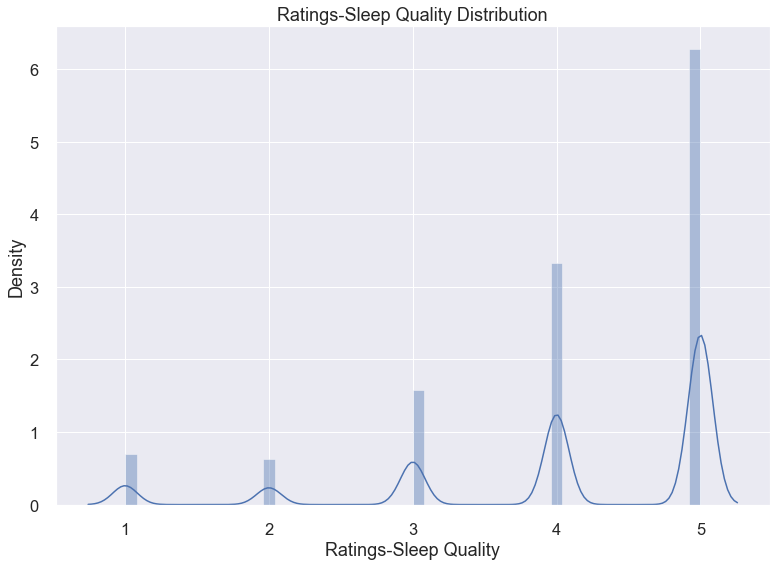

In [41]:
sns.distplot(df_clean['Ratings-Sleep Quality'].dropna()).set_title("Ratings-Sleep Quality Distribution");

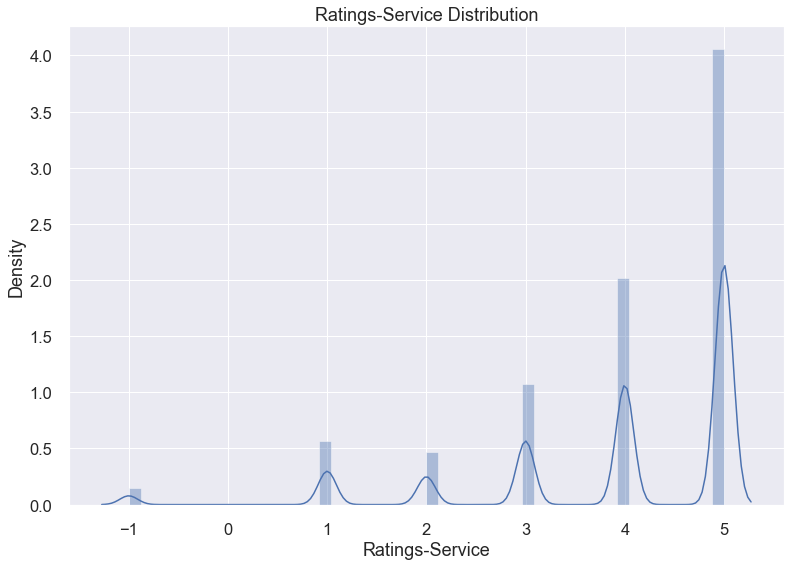

In [42]:
sns.distplot(df_clean['Ratings-Service'].dropna()).set_title("Ratings-Service Distribution");

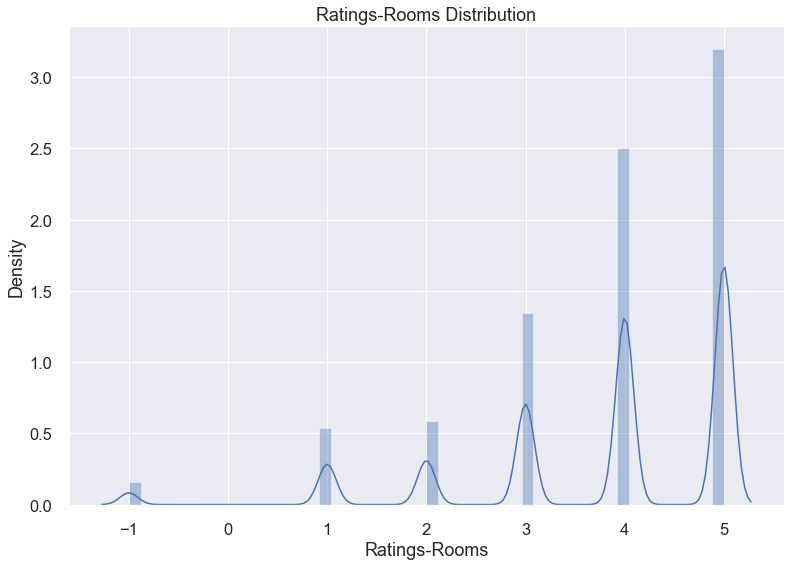

In [43]:
sns.distplot(df_clean['Ratings-Rooms'].dropna()).set_title("Ratings-Rooms Distribution");

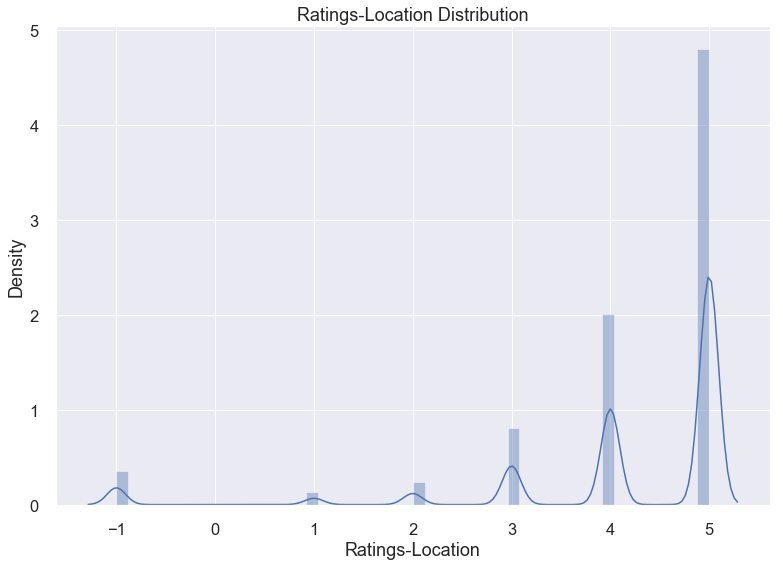

In [44]:
sns.distplot(df_clean['Ratings-Location'].dropna()).set_title("Ratings-Location Distribution");

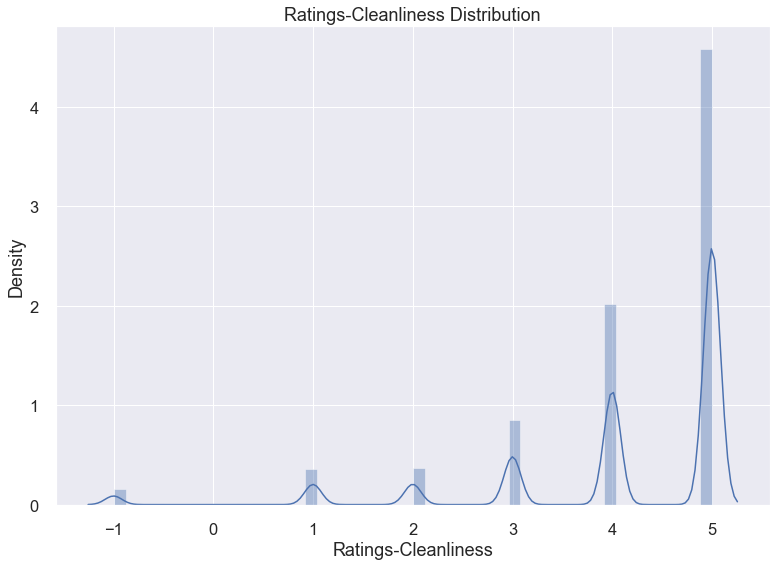

In [45]:
sns.distplot(df_clean['Ratings-Cleanliness'].dropna()).set_title("Ratings-Cleanliness Distribution");

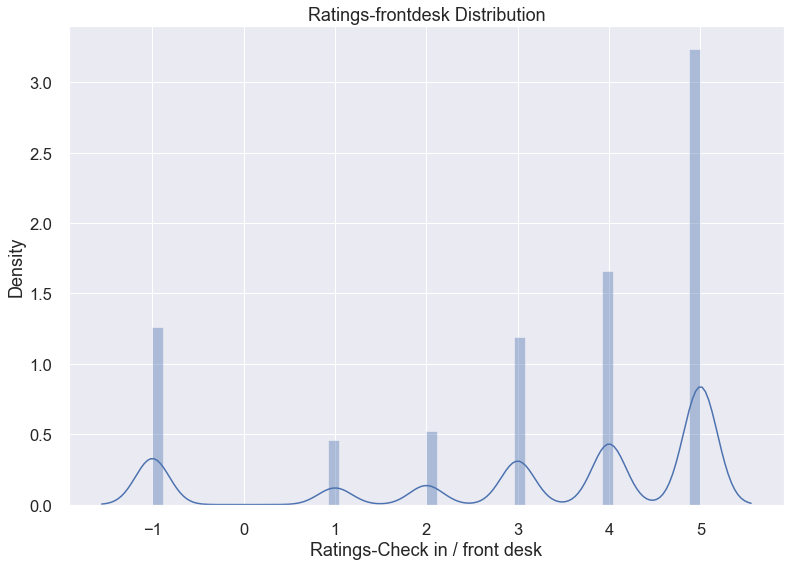

In [46]:
sns.distplot(df_clean['Ratings-Check in / front desk'].dropna()).set_title("Ratings-frontdesk Distribution");

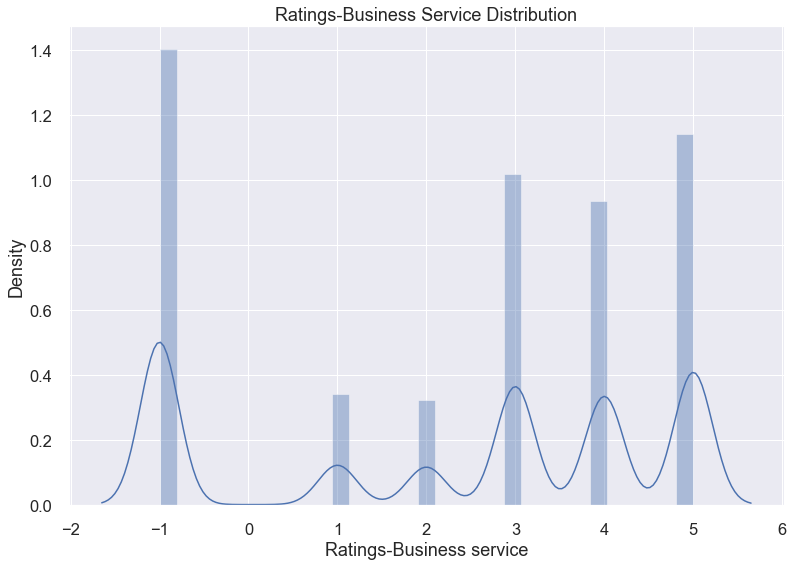

In [47]:
sns.distplot(df_clean['Ratings-Business service'].dropna()).set_title("Ratings-Business Service Distribution");

Except Business Service (and front desk), every Rating follow same distribution as Overall

In [41]:
df_clean[df_clean['Ratings-Business service'] == -1]

,Title,Author,Content,Ratings-Service,Ratings-Cleanliness,Ratings-Overall,Ratings-Value,Ratings-Sleep Quality,Ratings-Rooms,Ratings-Location,Ratings-Check in / front desk,Name,Price,HotelID,Ratings-Business service
1480,NaN,kangarooish,Value + Lake Union views This somewhat aged ho...,4.0,3.0,3.0,4.0,NaN,3.0,4.0,3.0,NaN,$85,100513,-1.0
1481,NaN,A TripAdvisor Member,Inexpensive and close to downtown without the ...,-1.0,-1.0,4.0,-1.0,NaN,-1.0,-1.0,-1.0,NaN,$85,100513,-1.0
1754,NaN,johnandjulie26,Great Adults Only Resort... our spot eve...,-1.0,-1.0,5.0,5.0,NaN,-1.0,-1.0,-1.0,NaN,$338,1005302,-1.0
1756,NaN,gerryb12,Wow!!! A must go!!! We just got back from a aw...,-1.0,-1.0,5.0,5.0,NaN,-1.0,-1.0,-1.0,NaN,$338,1005302,-1.0
1758,NaN,AllieR,Beautiful two weeks in Paradise I just returne...,-1.0,-1.0,3.0,-1.0,NaN,-1.0,-1.0,-1.0,NaN,$338,1005302,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539659,NaN,A TripAdvisor Member,Hasta la Vista My boyfriend and I had been tra...,1.0,-1.0,1.0,1.0,NaN,-1.0,-1.0,-1.0,NaN,$92,251397,-1.0
539660,NaN,National_Park_Junkie,A home in the tropics with a view and a small ...,-1.0,5.0,4.0,3.0,NaN,3.0,-1.0,-1.0,NaN,$92,251397,-1.0
539661,NaN,kmh316,Beautiful View We stayed 3 nights here and had...,3.0,5.0,4.0,3.0,NaN,3.0,-1.0,-1.0,NaN,$92,251397,-1.0
539662,NaN,A TripAdvisor Member,Fine for a place to rest your head My boyfrien...,3.0,5.0,3.0,5.0,NaN,3.0,-1.0,-1.0,NaN,$92,251397,-1.0


In [42]:
df_clean.iloc[1481]['Content']

'Inexpensive and close to downtown without the parking problems For the money this is a great pick. You can drive downtown in just minutes and the rooms are clean, pools is fine, and the views are wonderful. The setting is on the side of a hill overlooking Lake Union just 5 min. north of downtown. Not much within walking distance, and trying to find places to eat without going downtown was not too easy, but after a day it got easier to find things.'

Looks like -1 is same as NaN, because even with Ratings -1 is some fields, the Overall Rating is the average of only the positive Ratings.

#### analysing content column

##### cleaning text

In [25]:
lem = WordNetLemmatizer()
def clean_text(text):
    # remove special characters, punctuations, digits
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # convert to lowercase
    text = text.lower()
    
    # Convert to list from string
    text = text.split()
    
    # lemmatisation
    text = [lem.lemmatize(word) for word in text] 
    text = " ".join(text)
    return text

In [26]:
df_clean['Clean_Content'] = df_clean['Content'].progress_apply(lambda x: clean_text(x))

100%|████████████████████████████████| 873387/873387 [12:55<00:00, 1126.85it/s]


In [253]:
# def generate_corpus(rows):
#     corpus = list()
#     for i in rows:
#         # remove everything except alphabets
#         text = re.sub('[^a-zA-Z]', ' ', df_clean['Content'][i])
    
#         # convert to lowercase
#         text = text.lower()

#         # Convert to list from string
#         text = text.split()

#         # lemmatisation
#         lem = WordNetLemmatizer()
#         text = [lem.lemmatize(word) for word in text] 
        
#         text = " ".join(text)
#         corpus.append(text)
#     return corpus

In [ ]:
## Multiprocessing for speeding-up

# pool = Pool(3)
# total_iter = len(df_clean['Content'])
# corpus = tqdm(pool.imap(generate_corpus, range(total_iter)), total=total_iter) # Returns a list of lists
# # Flatten the list of lists
# corpus = [item for sublist in corpus for item in sublist]

##### top 20 unigrams

In [41]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [43]:
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(df_clean['Clean_Content'], n=20)
top_df = pd.DataFrame(top_words, columns=["Word", "Freq"])

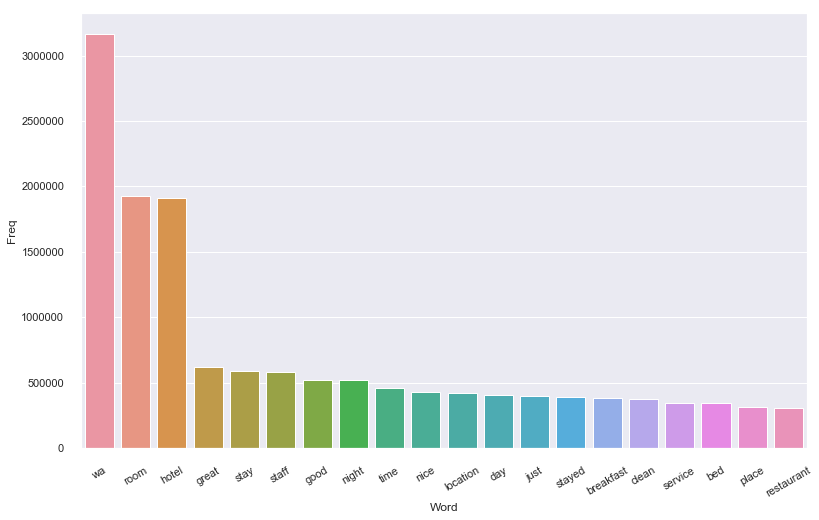

In [45]:
#Barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30);

#### top 20 bi-grams

In [59]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [60]:
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_bigram(df_clean['Clean_Content'], n=20)
top2_df = pd.DataFrame(top_words, columns=["Bi-gram", "Freq"])

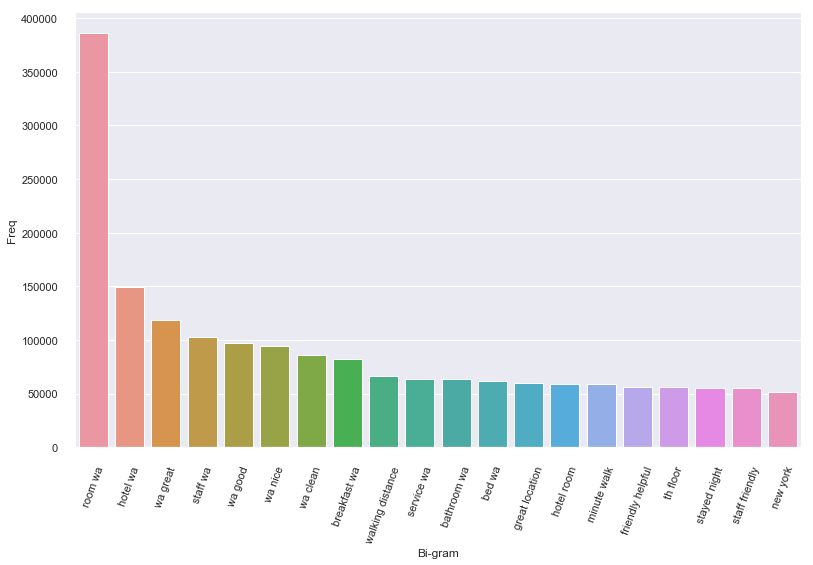

In [61]:
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=70);

1. Most users are talking about the features of hotels like rooms, staff, service, breakfast, location.
2. Most reviews are positive with words like good, great

#### content word count distribution

In [27]:
df_clean['Word_Count'] = df_clean['Clean_Content'].progress_apply(lambda x: len(str(x).split()))

100%|███████████████████████████████| 873387/873387 [00:12<00:00, 72145.52it/s]


In [28]:
print("Number of descriptions:",len(df_clean['Word_Count']),
      "\nAverage word count", df_clean['Word_Count'].mean(),
      "\nMinimum word count", df_clean['Word_Count'].min(),
      "\nMaximum word count", df_clean['Word_Count'].max())

Number of descriptions: 873387 
Average word count 177.07397980505777 
Minimum word count 0 
Maximum word count 7218


##### largest content

In [29]:
df_clean[df_clean['Word_Count']==7218]['Clean_Content'].item()

'loved it would definitely recommend detailed review we picked this resort based it beautiful beach price and positive review from frommers trip advisor our travel agent and a fellow co worker we stayed from july august it wa our st anniversary were both canadian from the greater toronto area and have traveled to a few all inclusives in the caribbean my wife is a year old teacher and i m a year old firefighter this website is an invaluable wealth of information so we want to reciprocate and share our experience price watched the price for month on website selloffvacations com and itravel prior to booking paid canadian plus tax per person for a one week stay we researched other hotel in punta cana including the riu property bahia principe per person plus tax and catalonia bavaro per person plus tax paradisus palma real received rave review but wa easily more per person during the same week our tour operator wa signature vacation more on them at the end of my review flight to punta cana 

Such a long review provided by a customer!

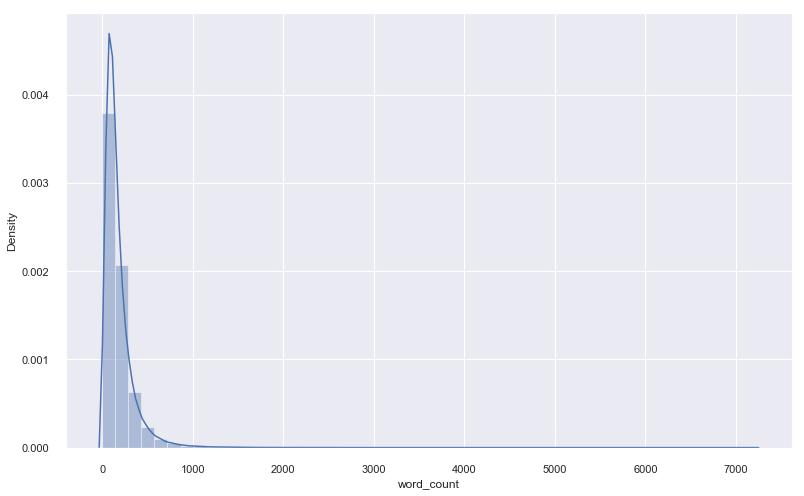

In [54]:
sns.distplot(df_clean['Word_Count']);

Most of the content are 0 to 200 length

### exploring Prices

In [33]:
df_clean['Price'].value_counts()

$109 - $278*             5209
$178 - $365*             4936
$144 - $305*             4170
$161 - $427*             3738
$209 - $557*             3380
                         ... 
$25                         1
$63                         1
$285 - $341*                1
" id="hotel_1090905">       1
$233                        1
Name: Price, Length: 4507, dtype: int64

In [42]:
df_clean[df_clean['Price'].str.contains('[a-zA-Z]')]

,Title,Author,Content,Ratings-Service,Ratings-Cleanliness,Ratings-Overall,Ratings-Value,Ratings-Sleep Quality,Ratings-Rooms,Ratings-Location,Ratings-Check in / front desk,Name,Price,HotelID,Ratings-Business service,Clean_Content,Word_Count
4379,NaN,rhymdunet,Une exp茅rience unique vue depuis la chambre,5.0,5.0,5.0,5.0,NaN,5.0,5.0,4.0,NaN,Unkonwn,1005628,5.0,une exp rience unique vue depuis la chambre,8
12445,“modern but soul less”,david m,"very modrn and stylish hotel,we atayed while p...",4.0,5.0,2.0,4.0,3.0,4.0,2.0,NaN,Barcelo Castellana Norte,$63 and up*,1008133,NaN,very modrn and stylish hotel we atayed while p...,78
12446,“Nice ultra modern hotel but a good way out of...,nickyg24,I stayed here on business as it was close to t...,4.0,4.0,3.0,3.0,3.0,3.0,2.0,NaN,Barcelo Castellana Norte,$63 and up*,1008133,NaN,i stayed here on business a it wa close to the...,68
12447,“Efficient but soulless business hotel”,restlessmover,Clean rooms that are comfortable enough but no...,3.0,5.0,3.0,2.0,2.0,3.0,4.0,NaN,Barcelo Castellana Norte,$63 and up*,1008133,NaN,clean room that are comfortable enough but not...,162
12448,“Nice Place for business traveler.”,georgeny01,Overall me and my wife went to Madrid on vacat...,4.0,4.0,2.0,4.0,4.0,3.0,2.0,NaN,Barcelo Castellana Norte,$63 and up*,1008133,NaN,overall me and my wife went to madrid on vacat...,117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538772,“Very disappointing”,JulieCLiverpool,Just arrived back from a three night stay at t...,3.0,2.0,2.0,2.0,NaN,2.0,NaN,NaN,Hotel Medium Cortezo,$83 and up*,250777,NaN,just arrived back from a three night stay at t...,207
538773,“Perfect location and value”,riskyman,I recently went to madrid and spent two days i...,4.0,4.0,4.0,5.0,NaN,4.0,NaN,NaN,Hotel Medium Cortezo,$83 and up*,250777,NaN,i recently went to madrid and spent two day in...,63
538774,“Excellent choice”,inkwave17,This was a really good hotel for a cost-consci...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,Hotel Medium Cortezo,$83 and up*,250777,NaN,this wa a really good hotel for a cost conscio...,95
538775,“Great Location and reasonable price would sta...,belizeLady,"I just returned from Madrid, Spain on Aug 9, 2...",NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,Hotel Medium Cortezo,$83 and up*,250777,NaN,i just returned from madrid spain on aug i sta...,93


Price column will require some clean up if we want to use it

### Recommendation

Few methods for recommending hotels:
    
1. Recommend top rated hotels. (problem: will always recommend same hotels irrespective of the input hotel. There's no learning involved)
2. Recommend based on pricing i.e. recommend top hotels of similar price. (still not very smart, as there are a lot of features other than price)
3. Recommend based on users -> if some users has rated a hotel high, recommend other hotels which those users has rated high. (might not work well as users are not unique here, a lot of users are "A TripAdvisor Member")
4. Recommend based on content/review similarity, which means recommend those hotels which have similar reviews by customers as that of input hotel. So if a user likes a hotel, there is a lot of chances that this user will also like other hotels with similar reviews. (we will use this technique)

In [135]:
df_clean['Author'].value_counts().head() ## a lot of users are just "A TripAdvisor Member"

A TripAdvisor Member                         41018
lass=                                         6873
Posted by an Accorhotels.com traveler         1541
Posted by a hotelsgrandparis.com traveler      178
Posted by an Easytobook.com traveler           156
Name: Author, dtype: int64

### Recommend based on content/review similarity

In [70]:
df_clean.head()

,Title,Author,Content,Ratings-Service,Ratings-Cleanliness,Ratings-Overall,Ratings-Value,Ratings-Sleep Quality,Ratings-Rooms,Ratings-Location,Ratings-Check in / front desk,Name,Price,HotelID,Ratings-Business service,Clean_Content,Word_Count
0,“Great place and location”,Nadine R,"Usually stay near the airport, but this trip w...",5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,Hilton Garden Inn Baltimore White Marsh,$135 - $193*,100407,NaN,usually stay near the airport but this trip we...,103
1,"“Nice stay, nice surroundings”",blt3116,Stayed at this Hilton for 2 nights. It was lik...,4.0,4.0,4.0,4.0,4.0,4.0,5.0,NaN,Hilton Garden Inn Baltimore White Marsh,$135 - $193*,100407,NaN,stayed at this hilton for night it wa like mos...,49
2,“Perfect for an overnight just off I-95”,ExSpec5,"Stayed there one night, December 16, on the wa...",5.0,5.0,4.0,3.0,3.0,5.0,5.0,NaN,Hilton Garden Inn Baltimore White Marsh,$135 - $193*,100407,NaN,stayed there one night december on the way fro...,80
3,“Great Hotel”,kevinlynch3,I just stayed here last weekend and have alrea...,5.0,5.0,5.0,4.0,5.0,5.0,5.0,NaN,Hilton Garden Inn Baltimore White Marsh,$135 - $193*,100407,NaN,i just stayed here last weekend and have alrea...,220
4,“good room for handicapped person”,nobumponalog,My mother who is 90 and I stayed one night on ...,5.0,5.0,5.0,4.0,5.0,5.0,5.0,NaN,Hilton Garden Inn Baltimore White Marsh,$135 - $193*,100407,NaN,my mother who is and i stayed one night on our...,83


#### NOTE: we don't want to recommend based on negative reviews. So removing reviews with Ratings-Overall less than 3

In [83]:
tempA = df_clean[df_clean['Ratings-Overall'] > 2]

#### combining the content/reviews for each hotel

In [84]:
df_recommend = tempA.groupby('HotelID')['Clean_Content'].apply(' '.join).reset_index()

In [85]:
tempB = tempA.groupby(by='HotelID', as_index=False)['Ratings-Overall'].agg({'Ratings-Overall': 'mean', 'Price': 'count'}).rename(columns={'Price': 'Count'})

In [88]:
df_recommend = pd.merge(df_recommend, tempB, on='HotelID').reset_index(drop=True)

In [89]:
df_recommend

,HotelID,Clean_Content,Ratings-Overall,Count
0,100407,usually stay near the airport but this trip we...,4.542857,35
1,100504,great location large clean room and very comfo...,4.575980,408
2,100505,we spent three night at the warwick last week ...,4.102128,235
3,100506,we stayed in downtown hotel seattle for two ni...,3.454545,11
4,100507,i checked with tripadvisor before booking at t...,4.753846,520
...,...,...,...,...
6393,2515688,michael doris wei stayed at the marina inn ove...,4.118280,93
6394,2515689,stayed here while i wa in town for the sema sh...,4.351648,91
6395,2515690,me and my colleague were here for one week ove...,3.940000,100
6396,2515691,stayed at the hampton inn for night and having...,4.269841,63


##### stopwords removal

In [92]:
df_recommend['Clean_Content'] = df_recommend['Clean_Content'].progress_apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

100%|██████████████████████████████████████| 6398/6398 [04:11<00:00, 25.40it/s]


In [93]:
df_recommend

,HotelID,Clean_Content,Ratings-Overall,Count
0,100407,usually stay near airport trip business north ...,4.542857,35
1,100504,great location large clean room comfortable be...,4.575980,408
2,100505,spent three night warwick last week check wa f...,4.102128,235
3,100506,stayed downtown hotel seattle two night bed co...,3.454545,11
4,100507,checked tripadvisor booking inn market like ev...,4.753846,520
...,...,...,...,...
6393,2515688,michael doris wei stayed marina inn easter wee...,4.118280,93
6394,2515689,stayed wa town sema show offered decent place ...,4.351648,91
6395,2515690,colleague one week overall stay wa pleasant ho...,3.940000,100
6396,2515691,stayed hampton inn night read review wa bit wa...,4.269841,63


#### set hotelID as index of dataframe

In [97]:
df_recommend.set_index('HotelID', inplace = True)

In [100]:
indices = pd.Series(df_recommend.index)

#### vectorize clean_content using tf-idf

In [98]:
tfidf = TfidfVectorizer(min_df=5)
tfidf_matrix = tfidf.fit_transform(df_recommend['Clean_Content'])

#### compute cosine_similarity of every content with every content

In [99]:
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

### get top 10 recommendations based on cosine_similarity of the content/reviews

In [154]:
def recommendations(ID, cosine_similarities=cosine_similarities):
    
    recommended_hotels = list()
    
    # get the index of the hotel with ID
    idx = indices[indices == ID].index[0]

    # create a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending = False)

    # get the indexes of the 10 most similar hotels except itself
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populate the list with the IDs of the top 10 matching hotels
    for i in top_10_indexes:
        recommended_hotels.append(list(df_recommend.index)[i])
        
    return ID, recommended_hotels ## return input HotelID, list of recommended_hotel_IDs

In [164]:
recommendations(224642)

(224642,
 [100407,
  1821731,
  1164933,
  119732,
  1147514,
  2515411,
  2515612,
  1436140,
  115483,
  1007816])

#### NOTE: Since every hotel does not have a Name, so I have used HotelID, as every Hotel has an HotelID. From that, we can get the name (if the hotel has one in the data)

##### get name from HotelID

In [114]:
df_name_id = df_clean[['HotelID', 'Name']]
df_name_id = df_name_id.drop_duplicates().reset_index(drop=True)
df_name_id.set_index('HotelID', inplace=True)

In [162]:
def get_name_from_hotelID(IDs):
    (input_ID, recommended_IDs) = IDs
    print("Input Hotel: ", df_name_id[df_name_id.index == input_ID]['Name'].item())
    print("\nRecommened Hotels:")
    for i in recommended_IDs:
        print(df_name_id[df_name_id.index == i]['Name'].item())

### Function to get recommended Hotels

In [165]:
get_name_from_hotelID(recommendations(224642)) ## Enter input HotelID

Input Hotel:  Hampton Inn Baltimore / White Marsh

Recommened Hotels:
Hilton Garden Inn Baltimore White Marsh
Sleep Inn & Suites Downtown Inner Harbor
Fairfield Inn & Suites Baltimore White Marsh
Hampton Inn San Diego Airport / SeaWorld
Hilton Baltimore
Hampton Inn San Diego Airport / SeaWorld
Hampton Inn San Diego Airport / SeaWorld
Quality Inn Downtown Baltimore
Hampton Inn & Suites Phoenix Airport South
Hilton Garden Inn Baltimore Inner Harbor


In [166]:
recommendations(224642)

(224642,
 [100407,
  1821731,
  1164933,
  119732,
  1147514,
  2515411,
  2515612,
  1436140,
  115483,
  1007816])

1. Looks like some Hotels with different ID have same name
2. Recommendation system provided similar Hotels